# Latar Belakang
Terkadang Badan Keamanan Terminal AS (TSA) membuat kesalahan. Orang bisa terluka dan harta benda bisa rusak, hilang, atau dicuri. Klaim umumnya diajukan terhadap TSA untuk cedera pribadi dan properti yang hilang atau rusak selama pemeriksaan dan mereka mencatat setiap klaim.

## Pernyataan Masalah
Menyelidiki hubungan antara item, claim amount, status, dan disposisi untuk memahami item mana yang lebih mungkin disetujui atau ditolak, dan bagaimana status klaim memengaruhi disposisinya.

# Data
Untuk menjawab pertanyaan di atas, kita akan menganalisa data peserta yang sudah dikumpulkan oleh perusahaan. Dataset dapat diakses [di sini](https://www.kaggle.com/datasets/terminal-security-agency/tsa-claims-database). 

Kumpulan data mencakup klaim yang diajukan antara tahun 2002 hingga 2015.

Claim Number
Date Received
Incident Date
Airport Code
Airport Name
Airline Name
Claim Type
Claim Site
Item
Claim Amount
Status
Close Amount
Disposition

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
import statsmodels.api as lm
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import re

In [ ]:
df = pd.read_csv('tsa_claims.csv')
df

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
0,0909802M,4-Jan-02,12/12/2002 0:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,$350.00,Approved,$350.00,Approve in Full
1,0202417M,2-Feb-02,1/16/2004 0:00,SEA,Seattle-Tacoma International,NaN,Property Damage,Checked Baggage,Luggage (all types including footlockers),$100.00,Settled,$50.00,Settle
2,0202445M,4-Feb-02,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,$278.88,Settled,$227.92,Settle
3,0909816M,7-Feb-02,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),$50.00,Approved,$50.00,Approve in Full
4,2005032379513,18-Feb-02,2/5/2005 0:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,$84.79,Approved,$84.79,Approve in Full
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204262,2015120427297,20-Nov-15,16-Oct-15,-,-,-,Property Damage,Checked Baggage,Baggage/Cases/Purses; Books; Magazines & Other...,-,-,NaN,NaN
204263,2015123027969,17-Dec-15,2-Dec-15,-,-,-,Property Damage,Checked Baggage,Audio/Video; Home Decor,-,-,NaN,NaN
204264,2016010428072,22-Dec-15,20-Dec-15,-,-,-,Passenger Property Loss,Checked Baggage,Clothing,-,-,NaN,NaN
204265,2016011328300,30-Dec-15,28-Dec-15,-,-,-,Passenger Property Loss,Checked Baggage,Tools & Home Improvement Supplies,-,-,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204267 entries, 0 to 204266
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Claim Number   204267 non-null  object
 1   Date Received  204004 non-null  object
 2   Incident Date  202084 non-null  object
 3   Airport Code   195743 non-null  object
 4   Airport Name   195743 non-null  object
 5   Airline Name   169893 non-null  object
 6   Claim Type     196354 non-null  object
 7   Claim Site     203527 non-null  object
 8   Item           200301 non-null  object
 9   Claim Amount   200224 non-null  object
 10  Status         204262 non-null  object
 11  Close Amount   135315 non-null  object
 12  Disposition    131359 non-null  object
dtypes: object(13)
memory usage: 20.3+ MB


Kolom claim amount dan close amount berisi nilai yang merepresentasikan jumlah uang, namun berisi '$', ' ' , ';' dan missing value.
Saya mengubah kolom tersebut agar berisi data yang memiliki tipe berupa angka (float) untuk mempermudah proses analisis.

In [ ]:
df['Claim Amount'] = df['Claim Amount'].astype('str')
new = []
for i in range(0, len(df)):
    new.append(df['Claim Amount'][i].replace('$',''))
df['Claim Amount'] = new
new = []
for i in range(0, len(df)):
    new.append(df['Claim Amount'][i].replace(';',''))
df['Claim Amount'] = new
new = []
for i in range(0, len(df)):
    new.append(df['Claim Amount'][i].replace(' ',''))
df['Claim Amount'] = new
new = []
for i in range(0, len(df)):
    new.append(df['Claim Amount'][i].replace('-','0'))
df['Claim Amount'] = new
new = []
for i in range(0, len(df)):
    new.append(df['Claim Amount'][i].replace('nan','0'))
df['Claim Amount'] = new
new = []
for i in range(0, len(df)):
    new.append(float(df['Claim Amount'][i]))
df['Claim Amount'] = new


In [ ]:
df['Claim Amount'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 204267 entries, 0 to 204266
Series name: Claim Amount
Non-Null Count   Dtype  
--------------   -----  
204267 non-null  float64
dtypes: float64(1)
memory usage: 1.6 MB


In [ ]:
df['Close Amount'] = df['Close Amount'].astype('str')
new = []
for i in range(0, len(df)):
    new.append(df['Close Amount'][i].replace('$',''))
df['Close Amount'] = new
new = []
for i in range(0, len(df)):
    new.append(df['Close Amount'][i].replace(';',''))
df['Close Amount'] = new
new = []
for i in range(0, len(df)):
    new.append(df['Close Amount'][i].replace(' ',''))
df['Close Amount'] = new
new = []
for i in range(0, len(df)):
    new.append(df['Close Amount'][i].replace('-','0'))
df['Close Amount'] = new
new = []
for i in range(0, len(df)):
    new.append(df['Close Amount'][i].replace('nan','0'))
df['Close Amount'] = new
new = []
for i in range(0, len(df)):
    new.append(float(df['Close Amount'][i]))
df['Close Amount'] = new


Jika terdapat nilai close amount dan nilai claim amount yang berbeda (dengan nilai perbedaan yang sangat kecil) tetapi pada kolom disposition bernilai 'Approve in Full' maka saya dapat mengubah nilai close amount sesuai dengan nilai claim amount

In [ ]:
for i in range(0, len(df)):
    if (df['Disposition'][i] == 'Approve in Full'):
        df['Close Amount'][i] = df['Claim Amount'][i]

Begitu juga demikian jika pada kolom status bernilai 'Approve in Full'

In [ ]:
for i in range(0, len(df)):
    if (df['Status'][i] == 'Approve in Full'):
        df['Close Amount'][i] = df['Claim Amount'][i]

In [ ]:
df['Close Amount'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 204267 entries, 0 to 204266
Series name: Close Amount
Non-Null Count   Dtype  
--------------   -----  
204267 non-null  float64
dtypes: float64(1)
memory usage: 1.6 MB


Mengecek dan membersihkan kolom Disposition

In [ ]:
df['Disposition'].unique()

array(['Approve in Full', 'Settle', nan, 'Deny'], dtype=object)

In [ ]:
df[df['Disposition'].isnull()]

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
8,14268,20-Jun-02,6/16/2002 0:00,PHX,Phoenix Sky Harbor International,NaN,Property Damage,Checkpoint,Computer - Laptop,2270.09,Canceled,0.0,NaN
13,13334,8-Jul-02,6/4/2002 0:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Southwest Airlines,NaN,Other,Clothing - Shoes; belts; accessories; etc.,450.00,Canceled,0.0,NaN
18,0616636L,18-Jul-02,NaN,NaN,NaN,NaN,NaN,Other,Luggage (all types including footlockers),0.00,Insufficient; one of the following items requi...,0.0,NaN
20,0616540L,22-Jul-02,NaN,NaN,NaN,NaN,NaN,Other,Other,0.00,Insufficient; one of the following items requi...,0.0,NaN
24,16403,12-Aug-02,7/19/2002 0:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Delta Air Lines,NaN,Other,Luggage (all types including footlockers),380.00,Canceled,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204262,2015120427297,20-Nov-15,16-Oct-15,-,-,-,Property Damage,Checked Baggage,Baggage/Cases/Purses; Books; Magazines & Other...,0.00,-,0.0,NaN
204263,2015123027969,17-Dec-15,2-Dec-15,-,-,-,Property Damage,Checked Baggage,Audio/Video; Home Decor,0.00,-,0.0,NaN
204264,2016010428072,22-Dec-15,20-Dec-15,-,-,-,Passenger Property Loss,Checked Baggage,Clothing,0.00,-,0.0,NaN
204265,2016011328300,30-Dec-15,28-Dec-15,-,-,-,Passenger Property Loss,Checked Baggage,Tools & Home Improvement Supplies,0.00,-,0.0,NaN


Saya ingin mengisi missing value pada kolom disposition dengan meggunakan nilai pada kolom status

In [ ]:
df[df['Disposition'].isnull()]['Status'].unique()

array(['Canceled',
       'Insufficient; one of the following items required: sum certain; statement of fact; signature; location of incident; and date.',
       'In litigation', 'Closed as a contractor claim', 'Denied',
       'In review', 'Claim entered', nan,
       'Claim has been assigned for further investigation', 'Deny', '-',
       'Settle', 'Approve in Full'], dtype=object)

In [ ]:
df[(df['Status'] == 'Approve in Full') & (df['Disposition'].isnull())]

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
145153,2010010567163,5-Jan-10,1/5/2010 0:00,XNA,Northwest Arkansas Regional,American Airlines,Passenger Property Loss,Checked Baggage,Cameras; Cameras,193.98,Approve in Full,193.98,NaN
145161,2010010867322,6-Jan-10,1/8/2010 10:30,BNA,Nashville International,American Airlines,Passenger Property Loss,Checkpoint,Office Equipment & Supplies,69.00,Approve in Full,69.00,NaN
145167,2010010867354,6-Jan-10,1/3/2010 0:00,CVG,Cincinnati/Northern Kentucky International,USAir,Property Damage,Checkpoint,Other,20.00,Approve in Full,20.00,NaN
145196,2010011267456,11-Jan-10,1/2/2010 13:15,DAL,Dallas Love Field,Southwest Airlines,Property Damage,Checkpoint,Baggage/Cases/Purses,12.00,Approve in Full,12.00,NaN
145199,2010011267471,11-Jan-10,1/6/2010 9:00,JFK,John F. Kennedy International,Virgin America,Property Damage,Checkpoint,Baggage/Cases/Purses; Personal Electronics,354.00,Approve in Full,354.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204187,2015061123082,2-Jun-15,1-May-15,ZZX,Non TSA Airport (motor vehicle),-,Property Damage,Motor Vehicle,-,777.12,Approve in Full,777.12,NaN
204189,2015070223650,29-Jun-15,8-May-15,ZZX,Non TSA Airport (motor vehicle),-,Employee Loss (MPCECA),Motor Vehicle,-,250.00,Approve in Full,250.00,NaN
204202,2015092425588,10-Sep-15,31-Aug-15,ZZX,Non TSA Airport (motor vehicle),-,Motor Vehicle,Other,-,656.56,Approve in Full,656.56,NaN
204203,2015102026116,29-Sep-15,22-Sep-15,ZZX,Non TSA Airport (motor vehicle),-,Motor Vehicle,Motor Vehicle,-,1520.85,Approve in Full,1520.85,NaN


Saya mengisi nilai missing value pada kolom disposition dengan 'Approve in Full' jika pada kolom status memiliki nilai 'Approve in Full'

In [ ]:
for i in range(0, len(df)):
    if ((df['Status'][i] == 'Approve in Full') & (df['Disposition'].isnull()[i])):
        df['Disposition'][i] = 'Approve in Full'

Saya mengisi nilai missing value pada kolom disposition dengan 'Deny' jika pada kolom status memiliki nilai 'Deny'

In [ ]:
for i in range(0, len(df)):
    if ((df['Status'][i] == 'Deny') & (df['Disposition'].isnull()[i])):
        df['Disposition'][i] = 'Deny'

Saya mengecek data duplikat pada dataset dan melakukan drop

In [ ]:
df[df.duplicated()]

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
16842,2004050450432,26-Sep-03,9/13/2003 0:00,NaN,NaN,NaN,Property Damage,Checked Baggage,DVD/CD Players,31.96,Canceled,0.0,NaN


In [ ]:
df.drop(16842, axis=0, inplace=True)

In [ ]:
df[df.duplicated()]

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition


Saya melakukan pengecekan data yang tidak terpakai seperti memiliki missing value pada kolom status dan kolom disposition

In [ ]:
df[(df['Disposition'].isnull()) & (df['Status'].isnull())]

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
97231,==> 2.csv.new <==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
145144,==> 3.csv.new <==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
186742,<BR>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
186743,==> 4.csv.new <==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
195599,==> 5.csv.new <==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN


In [ ]:
x = df[(df['Disposition'].isnull()) & (df['Status'].isnull())]
x.index

Int64Index([97231, 145144, 186742, 186743, 195599], dtype='int64')

In [ ]:
df.drop([97231, 145144, 186742, 186743, 195599], axis=0, inplace=True)

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df[df['Disposition'].isnull()]

,index,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
8,8,14268,20-Jun-02,6/16/2002 0:00,PHX,Phoenix Sky Harbor International,NaN,Property Damage,Checkpoint,Computer - Laptop,2270.09,Canceled,0.0,NaN
13,13,13334,8-Jul-02,6/4/2002 0:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Southwest Airlines,NaN,Other,Clothing - Shoes; belts; accessories; etc.,450.00,Canceled,0.0,NaN
18,18,0616636L,18-Jul-02,NaN,NaN,NaN,NaN,NaN,Other,Luggage (all types including footlockers),0.00,Insufficient; one of the following items requi...,0.0,NaN
20,20,0616540L,22-Jul-02,NaN,NaN,NaN,NaN,NaN,Other,Other,0.00,Insufficient; one of the following items requi...,0.0,NaN
24,24,16403,12-Aug-02,7/19/2002 0:00,BWI,Baltimore/Washington Intl Thurgood Marshall,Delta Air Lines,NaN,Other,Luggage (all types including footlockers),380.00,Canceled,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204256,204262,2015120427297,20-Nov-15,16-Oct-15,-,-,-,Property Damage,Checked Baggage,Baggage/Cases/Purses; Books; Magazines & Other...,0.00,-,0.0,NaN
204257,204263,2015123027969,17-Dec-15,2-Dec-15,-,-,-,Property Damage,Checked Baggage,Audio/Video; Home Decor,0.00,-,0.0,NaN
204258,204264,2016010428072,22-Dec-15,20-Dec-15,-,-,-,Passenger Property Loss,Checked Baggage,Clothing,0.00,-,0.0,NaN
204259,204265,2016011328300,30-Dec-15,28-Dec-15,-,-,-,Passenger Property Loss,Checked Baggage,Tools & Home Improvement Supplies,0.00,-,0.0,NaN


In [ ]:
df[(df['Disposition'].isnull()) & (df['Status'] == 'Denied')]


,index,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
1394,1394,0617589L,14-Jan-03,NaN,NaN,NaN,NaN,NaN,Other,Baby - Strollers; car seats; playpen; etc.,0.00,Denied,0.0,NaN
3475,3475,0311089L,11-Mar-03,12/23/2002 0:00,ATL,Hartsfield-Jackson Atlanta International Airport,NaN,Property Damage,Checked Baggage,Luggage (all types including footlockers),350.00,Denied,50.0,NaN
6345,6345,0513038L,13-May-03,3/29/2003 0:00,EWR,Newark International Airport,NaN,NaN,Checked Baggage,Clothing - Shoes; belts; accessories; etc.,0.00,Denied,0.0,NaN
6348,6348,0513049L,13-May-03,NaN,NaN,NaN,NaN,NaN,Other,Luggage (all types including footlockers),0.00,Denied,0.0,NaN
8733,8733,0617098L,17-Jun-03,5/2/2003 0:00,MIA,Miami International Airport,NaN,NaN,Checked Baggage,Luggage (all types including footlockers),116.00,Denied,0.0,NaN
18808,18809,1022464M,22-Oct-03,10/1/2003 0:00,LAX,Los Angeles International Airport,UAL,Property Damage,Checkpoint,Clothing - Shoes; belts; accessories; etc.,86.00,Denied,0.0,NaN
19339,19340,1105004M,5-Nov-03,4/29/2003 0:00,MSY,New Orleans International,American Airlines,Passenger Property Loss,Checked Baggage,Other,1300.00,Denied,0.0,NaN
21617,21618,1205105M,5-Dec-03,10/7/2003 0:00,LAS,McCarran International,America West,NaN,Checked Baggage,Other,89.25,Denied,0.0,NaN
23810,23811,0105268M,5-Jan-04,10/12/2003 0:00,MIA,Miami International Airport,Delta Air Lines,Property Damage,Checked Baggage,Luggage (all types including footlockers),120.00,Denied,0.0,NaN
26776,26777,0203000M,3-Feb-04,8/1/2003 0:00,PVD,TF Green Airport; Providence,USAir,Property Damage,Checkpoint,Cameras - Digital,559.30,Denied,0.0,NaN


In [ ]:
df['Disposition'].unique()

array(['Approve in Full', 'Settle', nan, 'Deny'], dtype=object)

mengisi missing value pada kolom disposition dengan 'Deny' jika kolom status memiliki nilai 'Denied'

In [ ]:
for i in range(0, len(df)):
    if ((df['Status'][i] == 'Denied') & (df['Disposition'].isnull()[i])):
        df['Disposition'][i] = 'Deny'

In [ ]:
df[(df['Disposition'].isnull()) & (df['Status'] == 'Denied')]

,index,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition


In [ ]:
df.to_csv('TSAbaru2.csv')

In [ ]:
df[df['Status'] == 'In litigation']

,index,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
56,56,21003,24-Sep-02,8/31/2002 0:00,PHL,Philadelphia International Airport,Delta Air Lines,Personal Injury,Other,Other,250000.00,In litigation,0.0,NaN
57,57,21021,24-Sep-02,8/31/2002 0:00,PHL,Philadelphia International Airport,Delta Air Lines,Personal Injury,Other,Eyeglasses - (including contact lenses),50000.00,In litigation,0.0,NaN
2582,2582,021300AL,12-Feb-03,10/11/2002 0:00,NaN,NaN,NaN,NaN,Other,Other,1450.00,In litigation,0.0,Deny
7783,7783,0604019L,4-Jun-03,4/24/2003 0:00,LNK,Lincoln Municipal,UAL,Passenger Property Loss,Checked Baggage,Clothing - Shoes; belts; accessories; etc.,80.00,In litigation,80.0,Approve in Full
8976,8976,0628504M,19-Jun-03,3/2/2003 0:00,LAX,Los Angeles International Airport,Southwest Airlines,Passenger Property Loss,Checked Baggage,Jewelry - Fine,2738.97,In litigation,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127557,127559,2008090549584,27-Aug-08,7/28/2008 0:00,JAN,Jackson International,Continental Airlines,Passenger Property Loss,Checkpoint,Jewelry - Fine,4000.00,In litigation,0.0,Deny
128011,128013,2008091049727,8-Sep-08,3/8/2007 0:00,DCA,Ronald Reagan Washington National Airport,NaN,Personal Injury,Checkpoint,NaN,85000.00,In litigation,0.0,NaN
133531,133533,2009031356228,29-Jan-09,1/13/2009 0:00,MCO,Orlando International Airport,Continental Airlines,Passenger Property Loss,Checked Baggage,Cameras - Digital; Cameras - Non-electronic (C...,491.30,In litigation,0.0,Deny
134415,134417,2009022555786,25-Feb-09,1/31/2009 0:00,IAH,Houston - George Bush Intercontinental Airport,NaN,Property Damage,Checked Baggage,Other,1400.00,In litigation,0.0,Deny


Mengisi nilai missing value pada kolom disposition bergantung pada nilai nilai unik yang berada pada kolom status

In [ ]:
df[df['Disposition'].isnull()]['Status'].unique()

array(['Canceled',
       'Insufficient; one of the following items required: sum certain; statement of fact; signature; location of incident; and date.',
       'In litigation', 'Closed as a contractor claim', 'In review',
       'Claim entered',
       'Claim has been assigned for further investigation', '-', 'Settle'],
      dtype=object)

"Canceled": Nilai ini kemungkinan menunjukkan bahwa klaim telah dibatalkan, baik oleh pemegang polis atau perusahaan asuransi. Hal ini dapat terjadi jika pemegang polis memutuskan untuk tidak melanjutkan klaim, atau jika perusahaan asuransi memutuskan bahwa klaim tersebut tidak sah.

"Insufficient; one of the following items required: sum certain; statement of fact; signature; location of incident; and date.": Nilai ini kemungkinan menunjukkan bahwa klaim tidak lengkap karena diperlukan informasi yang hilang, artinya pemegang polis belum t memberikan beberapa perincian penting tentang klaim tersebut, misalnya jumlah persisnya atau informasi spesifik tentang insiden tersebut.

"In litigation": Nilai ini mungkin menunjukkan bahwa klaim tersebut sedang disengketakan di pengadilan, baik pemegang polis atau perusahaan asuransi percaya bahwa klaim tersebut tidak ditangani dengan benar.

"Closed as a contractor claim": Nilai ini kemungkinan menunjukkan bahwa klaim ditutup oleh perusahaan asuransi setelah ditangani oleh kontraktor. Kontraktor telah menilai dan memperbaiki kerusakan tersebut.

"In review": Nilai ini kemungkinan menunjukkan bahwa klaim saat ini sedang ditinjau oleh perusahaan asuransi dan keputusan belum dibuat.

"Claim entered": Nilai ini kemungkinan menunjukkan bahwa klaim telah diajukan dan dimasukkan ke dalam sistem perusahaan asuransi, namun proses peninjauan belum dimulai.

"Claim has been assigned for further investigation": Nilai ini kemungkinan menunjukkan bahwa klaim saat ini sedang diselidiki oleh perusahaan asuransi untuk menentukan apakah klaim tersebut valid dan berapa banyak yang harus dibayar perusahaan

Saya memutuskan mengisi missing value pada kolom disposition dengan '-' yang memiliki nilai ekuivalen dengan 'belum mencapai keputusan akhir', pada beberapa nilai unik di kolom status

In [ ]:
for i in range(0, len(df)):
    if (df['Disposition'].isnull()[i]):
        if (df['Status'][i] == 'Canceled'):
            df['Disposition'][i] = '-'
        elif (df['Status'][i] == 'Insufficient; one of the following items required: sum certain; statement of fact; signature; location of incident; and date.'):
            df['Disposition'][i] = 'Deny'
        elif (df['Status'][i] == 'In litigation'):
            df['Disposition'][i] = '-'
        elif (df['Status'][i] == 'Closed as a contractor claim'):
            df['Disposition'][i] = 'Settle'
        elif (df['Status'][i] == 'In review'):
            df['Disposition'][i] = '-'
        elif (df['Status'][i] == 'Claim entered'):
            df['Disposition'][i] = '-'
        elif (df['Status'][i] == 'Claim has been assigned for further investigation'):
            df['Disposition'][i] = '-'
        elif (df['Status'][i] == '-'):
            df['Disposition'][i] = '-'
        elif (df['Status'][i] == 'Settle'):
            df['Disposition'][i] = 'Settle'

Melakukan cleaning pada kolom status

In [ ]:
df['Status'].isnull().sum()

0

Mengubah beberapa nilai pada kolom status yang memiliki arti atau nilai yang setara dengan beberapa kategori lainnya

In [ ]:
for i in range(len(df)):
    if (df['Status'][i] == 'Approved'):
        df['Status'][i] = 'Approve in Full'
for i in range(len(df)):
    if (df['Status'][i] == 'Denied'):
        df['Status'][i] = 'Deny'
for i in range(len(df)):
    if (df['Status'][i] == 'Settled'):
        df['Status'][i] = 'Settle'
df['Status'].unique()

array(['Approve in Full', 'Settle', 'Canceled', 'Deny',
       'Insufficient; one of the following items required: sum certain; statement of fact; signature; location of incident; and date.',
       'In litigation', 'Closed as a contractor claim', 'In review',
       'Claim entered',
       'Claim has been assigned for further investigation',
       'Pending response from claimant', '-'], dtype=object)

Lalu saya membuang beberapa baris data yang memiliki nilai '-' pada kolom status dan memiliki nilai 0 pada kolom claim amount

In [ ]:
df.drop(df[(df['Status'] == '-') & (df['Claim Amount'] == 0)].index.values, inplace=True)

Terdapat beberapa nilai 0 pada kolom close amount dikarenakan yang awalnya bernilai '-' maupun missing value saya isi dengan 0 untuk mengubah semuanya menjadi float.
oleh karena itu terdapat nilai 0 pada kolom close amount meskipun memiliki nilai 'settle' pada kolom status dan disposition. untuk mengisi nilai 0 tersebut saya menggunakan nilai rata-rata dari persentase jumlah close amount terhadap claim amount pada seluruh data yang memiliki nilai settle pada kolom status atau disposition.

In [ ]:
df[(df['Status'] == 'Settle') & (df['Close Amount'] == 0)]

,Unnamed: 0,index,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
84752,84752,84753,2006051206190,2-May-06,4/16/2006 0:00,CAK,Akron-Canton Regional,Air Tran Airlines(do not use),Passenger Property Loss,Checked Baggage,Watches - Inexpensive $100 or less,134.08,Settle,0.0,Settle
145149,145149,145152,2010011167421,4-Jan-10,1/1/2010 0:00,SEA,Seattle-Tacoma International,Delta Air Lines,Passenger Property Loss,Checkpoint,Computer & Accessories,1579.40,Settle,0.0,Settle
145153,145153,145156,2010010767294,5-Jan-10,1/2/2010 23:40,DAL,Dallas Love Field,Southwest Airlines,Property Damage,Checked Baggage,Baggage/Cases/Purses,72.00,Settle,0.0,Settle
145174,145174,145177,2010010867345,8-Jan-10,1/6/2010 14:57,MCO,Orlando International Airport,Delta Air Lines,Passenger Property Loss,Checked Baggage,Computer & Accessories,1575.00,Settle,0.0,Settle
145203,145203,145206,2010011367497,12-Jan-10,1/6/2010 0:00,OAK,Metropolitan Oakland International,Alaska Airlines,Passenger Property Loss,Checkpoint,Jewelry & Watches,466.20,Settle,0.0,Settle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204152,204152,204158,2015032721574,27-Mar-15,12-Mar-15,YKM,Yakima Air Terminal-Mcallister,American Airlines,Property Damage,Checked Baggage,Baggage/Cases/Purses,189.99,Settle,0.0,Settle
204156,204156,204162,2015080424556,30-Jul-15,20-Jul-15,YNG,Youngstown-Warren Regional,Allegiant Air,Passenger Property Loss,Checked Baggage,Baggage/Cases/Purses; Travel Accessories,3.00,Settle,0.0,Settle
204167,204167,204173,2014121619219,17-Mar-15,3-Dec-14,ZZX,Non TSA Airport (motor vehicle),-,Personal Injury,Motor Vehicle,-,4531.16,Settle,0.0,Settle
204170,204170,204176,2015032721575,27-Mar-15,9-Sep-14,ZZX,Non TSA Airport (motor vehicle),-,Motor Vehicle,Motor Vehicle,-,2206.35,Settle,0.0,Settle


membuat kolom baru untuk mengetahui persentase close amount terhadap claim amount

In [ ]:
df.reset_index(inplace=True)
baru = []
for i in range(len(df)):
    baru.append(df['Close Amount'][i]/df['Claim Amount'][i])
baru

In [ ]:
df['persentase settle'] = baru

lalu membuang beberapa data yang memiliki nilai settle pada kolom status namun bernilai 0 pada kolom claim amount

In [ ]:
df.drop(df[(df['Status'] == 'Settle') & (df['Claim Amount'] == 0)].index, inplace = True)

dan mencari nilai rata rata persentase close amount terhadap claim amount pada data yang memiliki nilai settle pada kolom status

In [ ]:
df[(df['Status'] == 'Settle') & (df['Close Amount'] > 0)]['persentase settle'].mean()

0.5153968347987549

mengubah data bernilai 0 pada kolom close amount dan memiliki nilai settle pada kolom status

In [ ]:
for i in range(0, len(df)):
    if df['Status'].iloc[i] == 'Settle':
        if df['Close Amount'].iloc[i] == 0:
            df['Close Amount'].iloc[i] = 0.5153968347987549 * df['Claim Amount'].iloc[i]

In [ ]:
df[(df['Status'] == 'Settle') & (df['Claim Amount'] == 0)]

,level_0,Unnamed: 0,index,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition,persentase settle


membuang kolom baru yang dibuat untuk membantu mengisi missing value

In [ ]:
df.drop('persentase settle', axis=1, inplace= True)

In [ ]:
df

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
0,0909802M,4-Jan-02,12/12/2002 0:00,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,350.00,Approve in Full,350.000000,Approve in Full
1,0202417M,2-Feb-02,1/16/2004 0:00,SEA,Seattle-Tacoma International,NaN,Property Damage,Checked Baggage,Luggage (all types including footlockers),100.00,Settle,50.000000,Settle
2,0202445M,4-Feb-02,11/26/2003 0:00,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,278.88,Settle,227.920000,Settle
3,0909816M,7-Feb-02,1/6/2003 0:00,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),50.00,Approve in Full,50.000000,Approve in Full
4,2005032379513,18-Feb-02,2/5/2005 0:00,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,84.79,Approve in Full,84.790000,Approve in Full
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191283,2015070223650,29-Jun-15,8-May-15,ZZX,Non TSA Airport (motor vehicle),-,Employee Loss (MPCECA),Motor Vehicle,-,250.00,Approve in Full,250.000000,Approve in Full
191284,2015092425588,10-Sep-15,31-Aug-15,ZZX,Non TSA Airport (motor vehicle),-,Motor Vehicle,Other,-,656.56,Approve in Full,656.560000,Approve in Full
191285,2015102026116,29-Sep-15,22-Sep-15,ZZX,Non TSA Airport (motor vehicle),-,Motor Vehicle,Motor Vehicle,-,1520.85,Approve in Full,1520.850000,Approve in Full
191286,2015101326019,13-Oct-15,16-Jul-15,ZZX,Non TSA Airport (motor vehicle),-,Motor Vehicle,Motor Vehicle,-,643.32,Approve in Full,643.320000,Approve in Full


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191288 entries, 0 to 191508
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Claim Number   191288 non-null  object 
 1   Date Received  191033 non-null  object 
 2   Incident Date  189235 non-null  object 
 3   Airport Code   182849 non-null  object 
 4   Airport Name   182849 non-null  object 
 5   Airline Name   157074 non-null  object 
 6   Claim Type     183531 non-null  object 
 7   Claim Site     190557 non-null  object 
 8   Item           187332 non-null  object 
 9   Claim Amount   191288 non-null  float64
 10  Status         191288 non-null  object 
 11  Close Amount   191288 non-null  float64
 12  Disposition    191288 non-null  object 
dtypes: float64(2), object(11)
memory usage: 20.4+ MB


In [ ]:
df[df['Claim Amount'] == 0]

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
14,0616771L,12-Jul-02,NaN,NaN,NaN,NaN,NaN,Other,Clothing - Shoes; belts; accessories; etc.,0.0,Deny,0.0,Deny
18,0616636L,18-Jul-02,NaN,NaN,NaN,NaN,NaN,Other,Luggage (all types including footlockers),0.0,Insufficient; one of the following items requi...,0.0,Deny
20,0616540L,22-Jul-02,NaN,NaN,NaN,NaN,NaN,Other,Other,0.0,Insufficient; one of the following items requi...,0.0,Deny
22,0616723L,5-Aug-02,NaN,NaN,NaN,NaN,NaN,Other,Clothing - Shoes; belts; accessories; etc.,0.0,Deny,0.0,Deny
27,0616777L,21-Aug-02,NaN,NaN,NaN,NaN,NaN,Other,Stereo Items & Accessories,0.0,Canceled,0.0,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191264,2015072023983,13-Jul-15,6-Jul-15,YNG,Youngstown-Warren Regional,Allegiant Air,Passenger Property Loss,Checked Baggage,Baggage/Cases/Purses,0.0,Deny,0.0,Deny
191268,2015042722126,27-Apr-15,22-Apr-15,YUM,Yuma International Airport,USAir,Passenger Property Loss,Checked Baggage,Computer & Accessories,0.0,Deny,0.0,Deny
191271,2015102126149,1-Oct-15,30-Sep-15,YUM,Yuma International Airport,American Airlines,Passenger Property Loss,Checkpoint,Currency,0.0,Deny,0.0,Deny
191279,2015050822378,5-May-15,9-Apr-15,ZZX,Non TSA Airport (motor vehicle),-,Motor Vehicle,Motor Vehicle,Other,0.0,Deny,0.0,Deny


Berikut adalah beberapa kemungkinan mengapa jumlah klaim adalah 0:

Klaim ditolak: Ada kemungkinan perusahaan asuransi menetapkan bahwa pemegang polis tidak berhak atas pembayaran klaim, sehingga jumlah klaim dicatat sebagai 0. (kolom status harus ditolak)

Pemegang polis tidak meminta pembayaran: Dalam beberapa kasus, pemegang polis dapat mengajukan klaim tetapi memilih untuk tidak meminta pembayaran dari perusahaan asuransi. Ini bisa jadi karena kerusakannya kecil dan tidak sebanding dengan kerumitan melalui proses klaim, atau karena pemegang polis dapat menyelesaikan masalah tanpa mengeluarkan biaya apa pun.

Pemegang polis tidak memberikan informasi yang cukup: Ada kemungkinan pemegang polis mengajukan klaim tetapi tidak memberikan informasi yang cukup kepada perusahaan asuransi untuk menentukan jumlah klaim. Dalam hal ini, jumlah klaim mungkin dicatat sebagai 0 hingga lebih banyak informasi tersedia. (kolom status tidak boleh mencukupi)

Melakukan cleaning pada kolom item

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191288 entries, 0 to 191287
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     191288 non-null  int64  
 1   Claim Number   191288 non-null  object 
 2   Date Received  191033 non-null  object 
 3   Incident Date  189235 non-null  object 
 4   Airport Code   182849 non-null  object 
 5   Airport Name   182849 non-null  object 
 6   Airline Name   157074 non-null  object 
 7   Claim Type     183531 non-null  object 
 8   Claim Site     190557 non-null  object 
 9   Item           187332 non-null  object 
 10  Claim Amount   191288 non-null  float64
 11  Status         191288 non-null  object 
 12  Close Amount   191288 non-null  float64
 13  Disposition    191288 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 20.4+ MB


Mencoba mengisi missing value pada kolom item dengan bantuan referensi dari nilai nilai pada kolom claim type

In [ ]:
df[df['Item'].isnull()]['Claim Type'].unique()

array(['Personal Injury', 'Motor Vehicle', 'Property Damage',
       'Passenger Property Loss', nan, 'Employee Loss (MPCECA)',
       'Passenger Theft'], dtype=object)

Nilai "Employee Loss (MPECECA)" di kolom jenis klaim dari kumpulan data klaim asuransi kemungkinan akan merujuk ke jenis klaim yang terkait dengan kehilangan atau cedera karyawan. Akronim "MPECECA" kemungkinan adalah singkatan dari "Efek Medis, Psikologis, Ekonomi dan Karir Melahirkan dan Adopsi". Jenis klaim ini dapat dilakukan jika karyawan mengalami efek samping, seperti masalah medis, masalah kesehatan mental, atau kehilangan pendapatan, karena melahirkan atau adopsi. Jenis klaim ini sering disebut sebagai klaim maternal-paternal.

Arti khusus dari "Employee Loss (MPECECA)" dapat berbeda-beda tergantung pada kebijakan perusahaan. Untuk mendapatkan pemahaman yang lebih baik tentang apa yang dicakup secara khusus oleh jenis klaim ini, harus mengacu pada kebijakan perusahaan atau menghubungi perusahaan secara langsung untuk mengklarifikasi.

Nilai "Passenger Theft" dalam kolom jenis klaim dari kumpulan data klaim asuransi kemungkinan akan mengacu pada jenis klaim yang terkait dengan pencurian barang pribadi penumpang. Ini dapat mencakup pencurian barang-barang seperti uang tunai, kartu kredit, perhiasan, elektronik, dan barang berharga lainnya yang dimiliki penumpang. Jenis klaim ini kemungkinan besar muncul ketika penumpang melaporkan bahwa barang miliknya dicuri saat transit, seperti di pesawat, kereta api, atau bus. Klaim ini dapat diajukan ke maskapai penerbangan, perusahaan transportasi, atau penyedia asuransi perjalanan.

Mengecek nilai nilai modus dari kolom item berdasarkan nilai nilai kolom type, guna untuk mengisi missing value pada kolom item yang memiliki nilai pada kolom claim type

In [ ]:
df[df['Claim Type'] == 'Personal Injury'][['Disposition']].groupby(df['Item']).count().sort_values(by='Disposition',ascending=False)

,Disposition
Item,
Other,211
-,135
Medicines,36
Luggage (all types including footlockers),23
Clothing - Shoes; belts; accessories; etc.,21
...,...
Computer - Laptop; Currency,1
Computer - Laptop; Luggage (all types including footlockers); Other,1
Computer - Laptop; Medical Equipment & Insturments; Other,1


In [ ]:
df[df['Claim Type'] == 'Motor Vehicle'][['Disposition']].groupby(df['Item']).count().sort_values(by='Disposition',ascending=False)

,Disposition
Item,
Other,74
-,64
Automobile Parts,14
Automobile Parts & Accessories,13
Jewelry & Watches,3
Baggage/Cases/Purses,2
Personal Electronics,2
Luggage (all types including footlockers),2
Other; Other,1


In [ ]:
df[df['Claim Type'] == 'Property Damage'][['Disposition']].groupby(df['Item']).count().sort_values(by='Disposition',ascending=False)

,Disposition
Item,
Luggage (all types including footlockers),16793
Other,12371
Baggage/Cases/Purses,4430
Computer - Laptop,4330
Clothing - Shoes; belts; accessories; etc.,4279
...,...
Cameras; Clothing; Food & Drink,1
Cameras; Clothing; Office Equipment & Supplies,1
Cameras; Cosmetics & Grooming; Home Decor,1


In [ ]:
df[df['Claim Type'] == 'Passenger Property Loss'][['Disposition']].groupby(df['Item']).count().sort_values(by='Disposition',ascending=False)

,Disposition
Item,
Other,20394
Clothing - Shoes; belts; accessories; etc.,9430
Jewelry - Fine,8474
Cameras - Digital,6999
Locks,5748
...,...
Cameras - Digital; Cosmetics - Perfume; toilet articles; medicines; soaps; etc.; Eyeglasses - (including contact lenses); Jewelry - Fine,1
Cameras - Digital; Cosmetics - Perfume; toilet articles; medicines; soaps; etc.; Handbags & Purses (leather or fabric); Jewelry - Costume,1
Cameras - Digital; Cosmetics - Perfume; toilet articles; medicines; soaps; etc.; Handbags & Purses (leather or fabric); Other,1


In [ ]:
df[df['Claim Type'] == 'Employee Loss (MPCECA)'][['Disposition']].groupby(df['Item']).count().sort_values(by='Disposition',ascending=False)

,Disposition
Item,
Other,155
Clothing - Shoes; belts; accessories; etc.,72
Locks,37
Jewelry - Fine,36
Eyeglasses - (including contact lenses),23
Cameras - Digital,21
Cosmetics - Perfume; toilet articles; medicines; soaps; etc.,14
Computer - Laptop,14
Luggage (all types including footlockers),14


In [ ]:
df[df['Claim Type'] == 'Passenger Theft'][['Disposition']].groupby(df['Item']).count().sort_values(by='Disposition',ascending=False)

,Disposition
Item,
Other,181
Clothing - Shoes; belts; accessories; etc.,54
Jewelry - Fine,54
Cameras - Digital,48
Locks,17
Computer - Laptop,16
Currency,14
Luggage (all types including footlockers),13
Eyeglasses - (including contact lenses),11


mengubah salah satu nilai unik pada kolom item guna mempermudah kelanjutan cleaning data

In [ ]:
for i in range(0, len(df)):
    if df['Item'][i] == 'Clothing - Shoes; belts; accessories; etc.':
        df['Item'][i] = 'Clothing (shoes, belts, accessories, etc)'

lalu mengisi missing value pada kolom item dengan nilai modus kolom item berdasarkan kolom type 

In [ ]:
for i in range(0, len(df)):
    if df['Item'].isnull()[i]:
        if df['Claim Type'][i] == 'Personal Injury':
            df['Item'][i] = 'Medicines'
        if df['Claim Type'][i] == 'Motor Vehicle':
            df['Item'][i] = 'Automobile Parts'
        if df['Claim Type'][i] == 'Property Damage':
            df['Item'][i] = 'Luggage (all types including footlockers)'
        if df['Claim Type'][i] == 'Passenger Property Loss':
            df['Item'][i] = 'Clothing (shoes, belts, accessories, etc)'
        if df['Claim Type'][i] == 'Employee Loss (MPCECA)':
            df['Item'][i] = 'Clothing (shoes, belts, accessories, etc)'
        if df['Claim Type'][i] == 'Passenger Theft':
            df['Item'][i] = 'Clothing (shoes, belts, accessories, etc)'

In [ ]:
df[df['Item'].isnull()]['Claim Type'].unique()

array([nan], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191288 entries, 0 to 191287
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   index          191288 non-null  int64  
 1   Unnamed: 0     191288 non-null  int64  
 2   Claim Number   191288 non-null  object 
 3   Date Received  191033 non-null  object 
 4   Incident Date  189235 non-null  object 
 5   Airport Code   182849 non-null  object 
 6   Airport Name   182849 non-null  object 
 7   Airline Name   157074 non-null  object 
 8   Claim Type     183531 non-null  object 
 9   Claim Site     190557 non-null  object 
 10  Item           190837 non-null  object 
 11  Claim Amount   191288 non-null  float64
 12  Status         191288 non-null  object 
 13  Close Amount   191288 non-null  float64
 14  Disposition    191288 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 21.9+ MB


membuang data dengan missing value pada kolom item dan claim type

In [ ]:
df.drop(df[(df['Item'].isnull()) & (df['Claim Type'].isnull())].index, inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190837 entries, 0 to 191287
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0.1   190837 non-null  int64  
 1   index          190837 non-null  int64  
 2   Unnamed: 0     190837 non-null  int64  
 3   Claim Number   190837 non-null  object 
 4   Date Received  190693 non-null  object 
 5   Incident Date  188952 non-null  object 
 6   Airport Code   182603 non-null  object 
 7   Airport Name   182603 non-null  object 
 8   Airline Name   156900 non-null  object 
 9   Claim Type     183531 non-null  object 
 10  Claim Site     190381 non-null  object 
 11  Item           190837 non-null  object 
 12  Claim Amount   190837 non-null  float64
 13  Status         190837 non-null  object 
 14  Close Amount   190837 non-null  float64
 15  Disposition    190837 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 24.8+ MB


In [ ]:
df['Item'].nunique()

4530

In [ ]:
pd.set_option('display.max_rows',None)

mengubah nilai pada kolom item yang memiliki nilai lebih dari satu item(barang) menjadi 'Multiple Items' guna mempermudah pengkategorian pada kolom item

In [ ]:
df.reset_index()

In [ ]:
for i in range(0, len(df['Item'])):
    if ';' in str(df['Item'][i]):
        df['Item'][i] = 'Multiple Items'

In [ ]:
df['Item'].nunique()

117

mengubah nilai '-' pada kolom item menjadi other

In [ ]:
for i in range(0, len(df)):
    if df['Item'][i] == '-':
        df['Item'][i] = 'Other'

In [ ]:
df.groupby(df['Item']).count().sort_values(by='Disposition',ascending=False).head(116)

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Claim Amount,Status,Close Amount,Disposition
Item,,,,,,,,,,,,
Other,38252,38230,37752,35827,35827,29055,36036,38151,38252,38252,38252,38252
Multiple Items,27353,27335,27283,26965,26965,25284,27073,27302,27353,27353,27353,27353
Luggage (all types including footlockers),19922,19896,19463,18236,18236,14011,18876,19847,19922,19922,19922,19922
"Clothing (shoes, belts, accessories, etc)",16938,16920,16690,15838,15838,12783,15898,16868,16938,16938,16938,16938
Jewelry - Fine,9891,9881,9782,9359,9359,7471,9190,9860,9891,9891,9891,9891
...,...,...,...,...,...,...,...,...,...,...,...,...
Typewriters,1,1,1,1,1,1,1,1,1,1,1,1
Bathroom Scales,1,1,1,1,1,1,1,1,1,1,1,1
Wigs (including hairpieces) $100 - $250,1,1,1,1,1,1,1,1,1,1,1,1


Karena analisis hanya menggunakan dari kolom 'Item' ke kanan, maka melakukan membuang kolom kolom dari kolom claim site ke kiri, dan membuang beberapa baris data yang memiliki nilai missing value di kolom kolom 'Date Received', 'Incident Date', 'Airport Code', 'Airport Name', 'Airline Name', 'Claim Type', dan 'Claim Site'

In [23]:
df[(df['Incident Date'].isnull()) & (df['Date Received'].isnull()) & (df['Airport Code'].isnull()) & (df['Airport Name'].isnull())]

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
96830,12627,NaN,NaN,NaN,NaN,NaN,NaN,Other,Other,0.0,Approve in Full,0.0,Approve in Full
96831,2004043050329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Approve in Full,0.0,Approve in Full
96832,2004062256795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Approve in Full,0.0,Approve in Full
96838,2004050650654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Canceled,0.0,-
96839,2004060354436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Canceled,0.0,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96981,2006050905774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Insufficient; one of the following items requi...,0.0,Deny
96982,2009110565153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Insufficient; one of the following items requi...,0.0,Deny
96983,2010052172027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Insufficient; one of the following items requi...,0.0,Deny
96984,2010111978015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,Insufficient; one of the following items requi...,0.0,Deny


In [24]:
df.drop(df[(df['Incident Date'].isnull()) & (df['Date Received'].isnull()) & (df['Airport Code'].isnull()) & (df['Airport Name'].isnull())].index, inplace=True)

In [26]:
df[(df['Incident Date'].isnull()) & (df['Date Received'].isnull())]

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
96812,0702536M,NaN,NaN,SEA,Seattle-Tacoma International,NaN,NaN,Other,Other,0.0,Approve in Full,0.0,Approve in Full
96835,0330001L,NaN,NaN,LAS,McCarran International,Delta Air Lines,NaN,Other,Jewelry - Fine,0.0,Canceled,0.0,-


In [27]:
df.drop(df[(df['Incident Date'].isnull()) & (df['Date Received'].isnull())].index, inplace=True)

In [28]:
df[(df['Airline Name'].isnull()) & (df['Airport Code'].isnull()) & (df['Airport Name'].isnull())]

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
14,0616771L,12-Jul-02,NaN,NaN,NaN,NaN,NaN,Other,"Clothing (shoes, belts, accessories, etc)",0.00,Deny,0.0,Deny
17,15361,15-Jul-02,3/11/2002 0:00,NaN,NaN,NaN,Personal Injury,Motor Vehicle,Luggage (all types including footlockers),110000.00,Deny,0.0,Deny
18,0616636L,18-Jul-02,NaN,NaN,NaN,NaN,NaN,Other,Luggage (all types including footlockers),0.00,Insufficient; one of the following items requi...,0.0,Deny
20,0616540L,22-Jul-02,NaN,NaN,NaN,NaN,NaN,Other,Other,0.00,Insufficient; one of the following items requi...,0.0,Deny
22,0616723L,5-Aug-02,NaN,NaN,NaN,NaN,NaN,Other,"Clothing (shoes, belts, accessories, etc)",0.00,Deny,0.0,Deny
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144512,2009122366750,16-Dec-09,11/7/2009 6:10,NaN,NaN,NaN,NaN,NaN,NaN,0.00,Insufficient; one of the following items requi...,0.0,Deny
144787,2009122466792,28-Dec-09,12/28/2009 0:00,NaN,NaN,NaN,Passenger Property Loss,Checked Baggage,Multiple Items,118.00,Insufficient; one of the following items requi...,0.0,Deny
144789,2009123066953,28-Dec-09,12/30/2009 0:00,NaN,NaN,NaN,Passenger Property Loss,Checked Baggage,Tool Chests & Tool Boxes (not in a vehicle)_,84.85,Insufficient; one of the following items requi...,0.0,Deny
144841,2009123167018,29-Dec-09,12/31/2009 11:59,NaN,NaN,NaN,Property Damage,Checkpoint,Luggage (all types including footlockers),0.00,Insufficient; one of the following items requi...,0.0,Deny


In [29]:
df.drop(df[(df['Airline Name'].isnull()) & (df['Airport Code'].isnull()) & (df['Airport Name'].isnull())].index, inplace=True)

In [30]:
df[(df['Claim Type'].isnull()) & (df['Claim Site'].isnull())]

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
18129,2005022776822,21-Oct-03,9/26/2003 0:00,MSP,Minneapolis/ St.Paul International Airport,NaN,NaN,NaN,Jewelry - Fine,0.00,Canceled,0.0,-
27329,2005021376079,10-Feb-04,NaN,I,Insurance Subrogation Claim,NaN,NaN,NaN,NaN,1940.12,Deny,0.0,Deny
27681,2005021276066,12-Feb-04,3/15/2004 0:00,I,Insurance Subrogation Claim,NaN,NaN,NaN,NaN,504.95,Deny,0.0,Deny
27683,2005021376076,12-Feb-04,NaN,I,Insurance Subrogation Claim,NaN,NaN,NaN,NaN,0.00,Deny,0.0,Deny
27684,2005021376082,12-Feb-04,NaN,I,Insurance Subrogation Claim,NaN,NaN,NaN,NaN,89.94,Deny,0.0,Deny
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142582,2009102764804,20-Oct-09,8/8/2009 0:00,JFK,John F. Kennedy International,Virgin Atlantic,NaN,NaN,Luggage (all types including footlockers),1000.00,Deny,0.0,Deny
143630,2009111965514,19-Nov-09,10/22/2009 0:00,IAD,Washington Dulles International,UAL,NaN,NaN,Alcoholic beverages,0.00,Insufficient; one of the following items requi...,0.0,Deny
143716,2009120366005,23-Nov-09,10/28/2009 12:00,DEN,Denver International Airport,Delta Air Lines,NaN,NaN,Computer - Laptop,940.00,Deny,0.0,Deny
144200,2008110451731,8-Dec-09,12/8/2009 8:49,ZZZ,Unspecified Personal Injury,NaN,NaN,NaN,NaN,0.00,Deny,0.0,Deny


In [31]:
df.drop(df[(df['Claim Type'].isnull()) & (df['Claim Site'].isnull())].index, inplace=True)

In [32]:
len(df)

184873

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184873 entries, 0 to 191287
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Claim Number   184873 non-null  object 
 1   Date Received  184759 non-null  object 
 2   Incident Date  184195 non-null  object 
 3   Airport Code   182681 non-null  object 
 4   Airport Name   182681 non-null  object 
 5   Airline Name   156961 non-null  object 
 6   Claim Type     179034 non-null  object 
 7   Claim Site     184653 non-null  object 
 8   Item           184713 non-null  object 
 9   Claim Amount   184873 non-null  float64
 10  Status         184873 non-null  object 
 11  Close Amount   184873 non-null  float64
 12  Disposition    184873 non-null  object 
dtypes: float64(2), object(11)
memory usage: 19.7+ MB


In [37]:
df[((df['Incident Date'].isnull()) | (df['Date Received'].isnull()) | (df['Airport Code'].isnull()) | (df['Airport Name'].isnull()) | (df['Airline Name'].isnull()) | (df['Claim Type'].isnull()) | (df['Claim Site'].isnull())) & (df['Disposition'] == 'Deny')]

,Claim Number,Date Received,Incident Date,Airport Code,Airport Name,Airline Name,Claim Type,Claim Site,Item,Claim Amount,Status,Close Amount,Disposition
9,2004102965797,25-Jun-02,5/4/2002 0:00,ATL,Hartsfield-Jackson Atlanta International Airport,NaN,Passenger Property Loss,Checkpoint,Jewelry - Fine,4457.29,Deny,0.0,Deny
15,15242,12-Jul-02,5/31/2002 0:00,BWI,Baltimore/Washington Intl Thurgood Marshall,American Airlines,NaN,Other,Luggage (all types including footlockers),200.00,Deny,0.0,Deny
16,15324,12-Jul-02,6/12/2002 0:00,BWI,Baltimore/Washington Intl Thurgood Marshall,NaN,NaN,Other,Luggage (all types including footlockers),50.00,Deny,0.0,Deny
19,0714534M,22-Jul-02,3/6/2002 0:00,NaN,NaN,Northwest Airlines,Property Damage,Other,Photographic Film,68.00,Deny,0.0,Deny
32,17201,9-Sep-02,8/19/2002 0:00,PVD,TF Green Airport; Providence,Delta Air Lines,NaN,Other,Other,250.00,Deny,0.0,Deny
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144760,2009123066966,28-Dec-09,10/6/2009 12:00,EUG,Eugene Airport/Mahlon Sweet Field,NaN,Passenger Property Loss,Checkpoint,"Clothing (shoes, belts, accessories, etc)",20.00,Deny,0.0,Deny
144791,2010010867314,28-Dec-09,12/28/2009 0:00,SPI,Abraham Lincoln Capital Airport; Springfield,NaN,Motor Vehicle,Motor Vehicle,Automobile Parts,0.00,Insufficient; one of the following items requi...,0.0,Deny
144866,2010010567097,30-Dec-09,12/11/2009 0:00,DAL,Dallas Love Field,NaN,Passenger Property Loss,Checkpoint,Multiple Items,50.00,Deny,0.0,Deny
144873,2010010567132,30-Dec-09,11/30/2009 11:20,IND,Indianapolis International,Southwest Airlines,Passenger Property Loss,NaN,Luggage (all types including footlockers),175.00,Deny,0.0,Deny


In [39]:
df.drop(df[((df['Incident Date'].isnull()) | (df['Date Received'].isnull()) | (df['Airport Code'].isnull()) | (df['Airport Name'].isnull()) | (df['Airline Name'].isnull()) | (df['Claim Type'].isnull()) | (df['Claim Site'].isnull())) & (df['Disposition'] == 'Deny')].index, inplace=True)

In [43]:
len(df)

171904

In [45]:
df['Item'].dropna(inplace=True)

Menghapus kolom yang tidak digunakan dalam analisis

In [46]:
df.drop(['Date Received', 'Incident Date',	'Airport Code',	'Airport Name',	'Airline Name',	'Claim Type',	'Claim Site'], axis=1, inplace=True)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171904 entries, 0 to 191287
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Claim Number  171904 non-null  object 
 1   Item          171844 non-null  object 
 2   Claim Amount  171904 non-null  float64
 3   Status        171904 non-null  object 
 4   Close Amount  171904 non-null  float64
 5   Disposition   171904 non-null  object 
dtypes: float64(2), object(4)
memory usage: 9.2+ MB


In [49]:
df.to_csv(r'TSAanalisis.csv', index=False)

In [51]:
print("Maximum amount claimed : ", df['Claim Amount'].max())
print("Average amount claimed : ", df['Claim Amount'].mean())

Maximum amount claimed :  1000000000.0
Average amount claimed :  8838.5841609852


In [52]:
df[df['Claim Amount'] == 1000000000]

,Claim Number,Item,Claim Amount,Status,Close Amount,Disposition
124609,2008063046385,Medicines,1.000000e+09,Deny,0.0,Deny


In [53]:
print("Maximum closed amount  : ", df['Close Amount'].max())
print("Average closed amount  : ", df['Close Amount'].mean())

Maximum closed amount  :  250000.0
Average closed amount  :  91.88723202867412


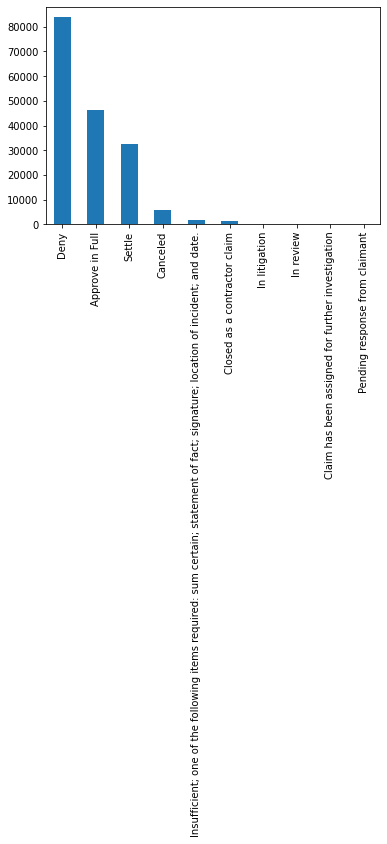

In [55]:
vc = df['Status'].value_counts().head(20).plot(kind='bar')
plt.show()

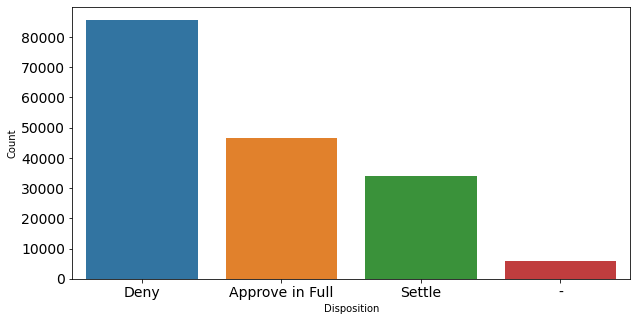

In [54]:
dispos = df['Disposition'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(dispos.index, dispos.values)
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

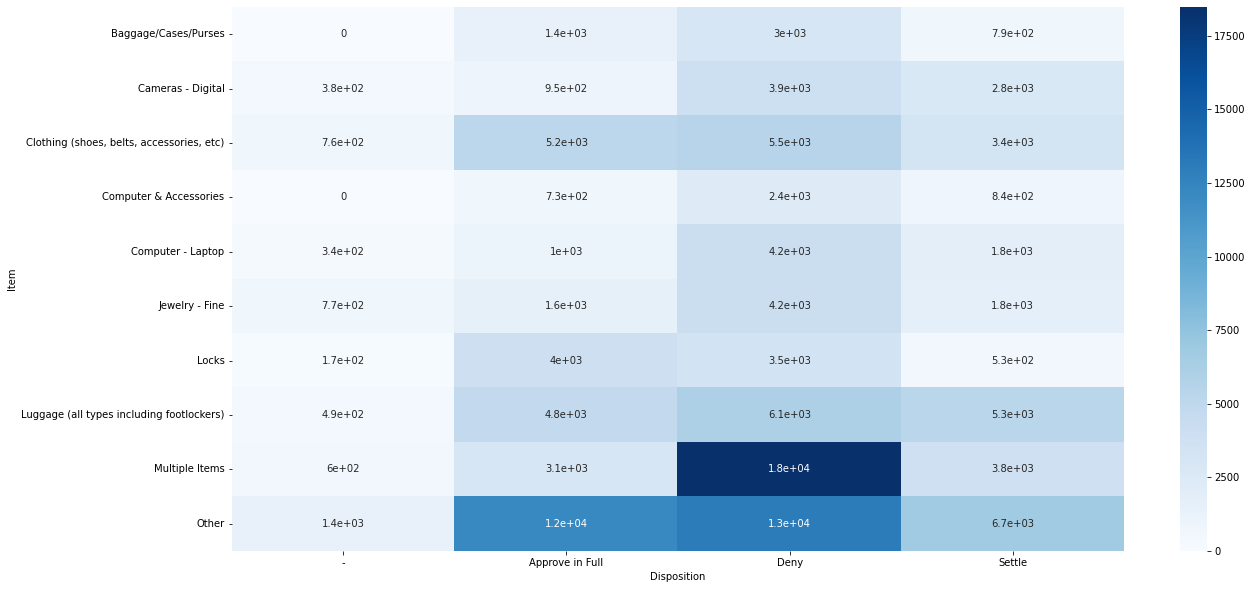

In [70]:
top_10_items = df['Item'].value_counts().nlargest(10)
df_top_10 = df[df['Item'].isin(top_10_items.index)]
item_disposition = pd.crosstab(df_top_10['Item'], df_top_10['Disposition'])
plt.figure(figsize=(20,10))
sns.heatmap(item_disposition, annot=True, cmap='Blues')
plt.xlabel('Disposition')
plt.ylabel('Item')
plt.show()

In [81]:

top_50_items = df['Item'].value_counts().nlargest(50)
df_top_50 = df[df['Item'].isin(top_50_items.index)]
df_top_50 = df_top_50.groupby(['Item','Disposition']).size()
df_top_50 = df_top_50.reset_index(name='counts')
df_top_50['percentage'] = df_top_50.groupby(['Item'])['counts'].apply(lambda x: x/x.sum()*100)
df_top_50.sort_values(by='percentage',ascending=False)

,Item,Disposition,counts,percentage
12,Automobile Parts & Accessories,Deny,177,82.710280
2,Alcoholic beverages,Deny,362,81.531532
86,Jewelry & Watches,Deny,2393,76.871185
70,GPS - Global Positioning System,Deny,428,75.618375
146,Professional Equipment,Deny,78,73.584906
...,...,...,...,...
115,Multiple Items,-,604,2.323613
122,Musical Instruments - Other - Over $250,-,8,2.253521
0,Alcoholic beverages,-,10,2.252252
168,Video Recordings (blank & commercial),-,2,2.222222


In [84]:
df_pivot = df_top_50.pivot_table(index='Item',columns='Disposition',values='percentage')
df_pivot.sort_index(inplace=True)
df_pivot


Disposition,-,Approve in Full,Deny,Settle
Item,,,,
Alcoholic beverages,2.252252,11.261261,81.531532,4.954955
Audio/Video,NaN,27.007299,59.489051,13.503650
Automobile Parts,8.000000,29.714286,50.857143,11.428571
Automobile Parts & Accessories,NaN,13.551402,82.710280,3.738318
Baggage/Cases/Purses,NaN,26.911256,57.913945,15.174798
Cameras,NaN,13.808267,73.175022,13.016711
Cameras - Digital,4.774338,11.761780,48.501803,34.962079
Cell Phones,6.260575,28.087986,40.778342,24.873096
Clothing,NaN,34.578947,55.000000,10.421053


Setelah melakukan beberapa aggregasi dapat terlihat 50 item dengan jumlah claim terbanyak dengan persentase proporsi mereka mendapat disposisi Approve, settle, dan deny

In [96]:
df_pivot[df_pivot['Approve in Full'] == df_pivot['Approve in Full'].max()]

Disposition,-,Approve in Full,Deny,Settle
Item,,,,
Travel Accessories,NaN,56.933862,38.098141,4.967998


In [97]:
df_pivot[df_pivot['Deny'] == df_pivot['Deny'].max()]

Disposition,-,Approve in Full,Deny,Settle
Item,,,,
Automobile Parts & Accessories,NaN,13.551402,82.71028,3.738318


In [98]:
df_pivot[df_pivot['Settle'] == df_pivot['Settle'].max()]

Disposition,-,Approve in Full,Deny,Settle
Item,,,,
PDA - Personal Data Assistants,6.451613,17.473118,34.677419,41.397849


In [99]:
df_pivot[df_pivot['Approve in Full'] == df_pivot['Approve in Full'].min()]

Disposition,-,Approve in Full,Deny,Settle
Item,,,,
GPS - Global Positioning System,6.713781,4.946996,75.618375,12.720848


In [100]:
df_pivot[df_pivot['Deny'] == df_pivot['Deny'].min()]

Disposition,-,Approve in Full,Deny,Settle
Item,,,,
Eyeglasses - (including contact lenses),4.079254,39.97669,26.486014,29.458042


In [101]:
df_pivot[df_pivot['Settle'] == df_pivot['Settle'].min()]

Disposition,-,Approve in Full,Deny,Settle
Item,,,,
Food & Drink,NaN,36.472149,59.814324,3.713528


In [104]:
approved_percentage = df_pivot['Approve in Full']
denied_percentage = df_pivot['Deny']
approved_top_10 = approved_percentage.sort_values(ascending=False).head(10)
denied_top_10 = denied_percentage.sort_values(ascending=False).head(10)


## Konklusi
Dari tabel pivot yang dihasilkan, terlihat jelas bahwa item dengan persentase klaim disetujui tertinggi adalah "Travel Accessories" dengan sekitar 56%. Sedangkan "GPS - Global Positioning System" memiliki persentase klaim yang disetujui paling rendah, yaitu sekitar 4.9%.

Untuk klaim yang ditolak, jelas bahwa "Automobile Parts & Accessories" memiliki persentase tertinggi sekitar 82%. Sedangkan "Eyeglasses - (including contact lenses)" memiliki persentase penolakan klaim terendah dengan kisaran 26%.

Untuk klaim yang diselesaikan(settled), jelas bahwa "PDA - Personal Data Assistants" memiliki persentase tertinggi sekitar 41%. Sedangkan "Food & Drink" memiliki persentase penolakan klaim terendah dengan kisaran 3.7%

In [105]:
approved_top_10

Item
Travel Accessories                         56.933862
Locks                                      48.852459
Home Decor                                 41.947566
Eyeglasses - (including contact lenses)    39.976690
Photographic Film                          39.181287
Fish/Game                                  37.591241
Medical Equipment & Insturments            36.713287
Other                                      36.578869
Food & Drink                               36.472149
Household Items                            36.244541
Name: Approve in Full, dtype: float64

In [106]:
denied_top_10

Item
Automobile Parts & Accessories           82.710280
Alcoholic beverages                      81.531532
Jewelry & Watches                        76.871185
GPS - Global Positioning System          75.618375
Professional Equipment                   73.584906
Cameras                                  73.175022
Video Recordings (blank & commercial)    72.222222
Multiple Items                           71.062553
Tools - Manual (not in a vehicle)        68.141593
Jewelry - Costume                        67.245989
Name: Deny, dtype: float64

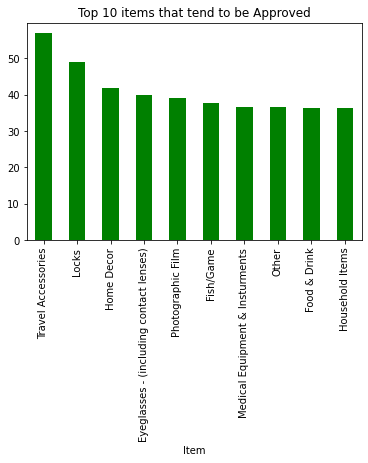

In [108]:
approved_top_10.plot.bar(color='green',title='Top 10 items that tend to be Approved')

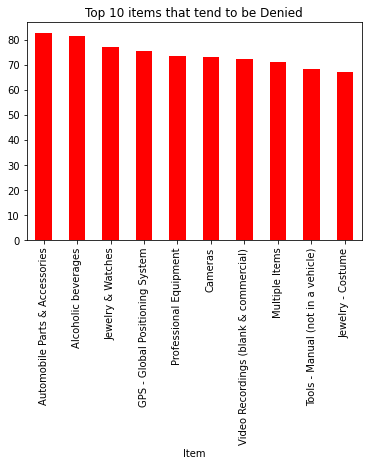

In [107]:
denied_top_10.plot.bar(color='red',title='Top 10 items that tend to be Denied')


## **Rekomendasi**
Berdasarkan temuan ini, rekomendasinya adalah agar perusahaan fokus pada peningkatan tingkat persetujuan untuk "Automobile Parts & Accessories" dengan mengidentifikasi alasan tingginya persentase klaim yang ditolak untuk item ini. Selain itu, perusahaan harus berusaha mempertahankan tingkat persetujuan yang tinggi untuk "Travel Accessories". Saya merekomendasikan agar perusahaan berfokus untuk mempertahankan tingkat persetujuan yang tinggi untuk item teratas yang cenderung disetujui, dengan mengidentifikasi alasan tingkat persetujuan yang tinggi dan mencari cara untuk mereplikasi faktor tersebut untuk item lainnya. Untuk item yang cenderung ditolak, perusahaan harus fokus untuk mengidentifikasi alasan tingkat penolakan yang tinggi dan menemukan cara untuk mengatasi masalah tersebut guna meningkatkan tingkat persetujuan untuk item tersebut. 

Penting untuk dicatat bahwa tingkat persetujuan yang tinggi untuk klaim tidak selalu berarti baik untuk bisnis. Dalam beberapa kasus, tingkat persetujuan yang tinggi dapat mengindikasikan bahwa perusahaan tidak memeriksa klaim dengan benar dan akibatnya, membayar klaim yang tidak valid. Hal ini dapat menyebabkan kerugian finansial bagi perusahaan.

Namun, penting juga untuk dicatat bahwa tingkat persetujuan yang tinggi dapat menjadi tanda bahwa perusahaan memiliki proses klaim yang baik dan efisien dalam memproses dan membayar klaim yang valid. Selain itu, tingkat persetujuan yang tinggi dapat menyebabkan peningkatan kepuasan dan loyalitas pelanggan.

Jadi, rekomendasinya adalah untuk menyelidiki alasan di balik tingkat persetujuan yang tinggi, untuk memastikan bahwa perusahaan tidak membayar klaim yang tidak valid sekaligus menjaga hubungan baik dengan pelanggan dengan menyetujui klaim yang sah dengan cepat.

Poin lainnya adalah, penting juga untuk mempertimbangkan tingkat persetujuan dalam konteks keseluruhan volume klaim dan dampak finansial dari klaim terhadap bisnis. Tingkat persetujuan yang tinggi untuk sejumlah kecil klaim berdampak rendah mungkin tidak sepenting tingkat persetujuan yang tinggi untuk sejumlah besar klaim berdampak tinggi.